Describe an algorithm that compares 2 images - one with few stars and one with many stars
The algorithm matches each star in the small image to its corresponding star in the large image.

- Inputs:
    img_S: sparse image
    img_L: dense image
    X: The number of stars to use for alignment (e.g., 2 or 3).

- Algorithm:
    S ← A list of coordinates of stars in the sparse image and their radius and brightness (x,y,r,b).
    L ← A list of coordinates of stars in the dense image their radius and brightness. (|L| > |S|).
    1) bright_s ← 5 brightest stars of S

    2) Generate Subsets:
        Iterate over all combinations of X stars from bright_s — denote each as S_X.
        For each S_X, iterate over all combinations of X stars from L — denote each as L_X.

    3) Compute Transformation:
        For each pair (S_X, L_X):
        Estimate a geometric transformation (e.g., scaling + translation) that maps S_X onto L_X.
        Apply this transformation to all stars in S, resulting in a transformed set S'.
    4) Evaluate Fit:
        For each star in S', check if there is a nearby star in L (within some small threshold distance ε).
        Count the number of unmatched stars (stars in S' with no close counterpart in L).
    5) Select Best Match:
        Keep track of the transformation with the fewest unmatched stars.
        Return this transformation (and optionally, the matching star pairs).

    6) Output:
        - The best matching transformation from the sparse image to the dense one.
        - The minimal number of unmatched stars.
        - Optionally, the list of matched star pairs.




In [11]:
import numpy as np
from itertools import combinations
from scipy.spatial.distance import cdist
from sqlalchemy import false

from process_star_img import detect_stars


def compute_similarity_transform(src, dst):
    src = np.array(src)
    dst = np.array(dst)

    src_mean = np.mean(src, axis=0)
    dst_mean = np.mean(dst, axis=0)

    src_centered = src - src_mean
    dst_centered = dst - dst_mean

    U, S, Vt = np.linalg.svd(np.dot(dst_centered.T, src_centered))
    R = np.dot(U, Vt)

    scale = np.trace(np.dot(dst_centered.T, np.dot(R, src_centered))) / np.sum(src_centered ** 2)
    translation = dst_mean - scale * np.dot(src_mean, R.T)

    return scale, R, translation


def apply_transform(points, scale, rotation, translation, scale_radius=False):
    points = np.array(points)
    transformed = points.copy()
    transformed[:, 0:2] = scale * np.dot(points[:, 0:2], rotation.T) + translation
    if scale_radius:
        transformed[:, 2] = scale * points[:, 2]
    return transformed


def find_matches(transformed_points, original_sparse, target_points, epsilon):  #todo: fix
    matches = []
    distances = cdist(transformed_points, target_points)
    for i, row in enumerate(distances):
        min_dist = np.min(row)
        if min_dist <= epsilon:
            j = np.argmin(row)
            matches.append([original_sparse[i].tolist(), target_points[j].tolist()])
    return matches


def is_same_star(star1, star2, epsilon):
    x_1, y_1, r_1, b_1 = star1
    x_2, y_2, r_2, b_2 = star2
    dif_x = abs(x_1 - x_2)
    dif_y = abs(y_1 - y_2)
    dif_r = abs(r_1 - r_2)

    return dif_x <= epsilon and dif_y <= epsilon


def match_stars(sparse_path, dense_path, X=2, epsilon=2.0, max_dense_combinations=10000):
    sparse = detect_stars(sparse_path)
    dense = detect_stars(dense_path)
    sparse = np.array(sparse)
    dense = np.array(dense)

    print("num of stars in sparse:", len(sparse))
    print("num of stars in dense:", len(dense))

    # Sort sparse by brightness and keep brightests
    sparse = sorted(sparse, key=lambda s: s[2], reverse=True)[:10]

    best_mismatch = float('inf')
    best_transform = None
    best_matches = []

    sparse_combos = list(combinations(range(len(sparse)), X))
    dense_combos = list(combinations(range(len(dense)), X))

    if len(dense_combos) > max_dense_combinations:
        print(" the number of combinations exceeds a threshold")
        np.random.seed(0)
        sampled = np.random.choice(len(dense_combos), max_dense_combinations, replace=False)
        dense_combos = [dense_combos[i] for i in sampled]

    for s_idx in sparse_combos:
        S_X = [sparse[i][0:2] for i in s_idx]

        for d_idx in dense_combos:
            L_X = [dense[i][0:2] for i in d_idx]

            scale, R, translation = compute_similarity_transform(S_X, L_X)
            if scale is None:
                continue

            transformed_sparse = apply_transform(sparse, scale, R, translation, True)
            # go through each star in dence and check if it have a fitting star in transformed sparse (check if they have the same x,y coardinants +- epsilon) count haw may mismatches we found

            mismatches = 0
            matches = []

            for star_1 in dense:
                found = False
                for star_2 in transformed_sparse:
                    if is_same_star(star_1, star_2, epsilon):
                        found = True
                        matches.append((star_1[:2], star_2[:2]))
                        break
                if not found:
                    mismatches += 1

            if mismatches <= best_mismatch:
                best_mismatch = mismatches
                best_transform = (scale, R, translation)
                best_matches = matches

    return best_transform, best_mismatch, best_matches






In [12]:

first_img_path = "stars pics/fr1.jpg"
second_img_path = "stars pics/fr2.jpg"
first_img_codrs = detect_stars(first_img_path)
second_img_cords = detect_stars(second_img_path)

In [13]:
from pprint import pprint

transform, mismatches, matches = match_stars(first_img_path,second_img_path, X=2, epsilon=10.0)

print("Best Scale:", transform[0])
print("Best Translation:", transform[1])
print("Unmatched Stars:", mismatches)
print("Matches:")
for pair in matches:
    print(f"  Sparse star {pair[0]} matched to Dense star {pair[1]}")


num of stars in sparse: 20
num of stars in dense: 25
Best Scale: 0.991080117794972
Best Translation: [[ 0.99684477 -0.07937566]
 [ 0.07937566  0.99684477]]
Unmatched Stars: 21
Matches:
  Sparse star [ 320.5 3278.5] matched to Dense star [ 326.48389548 3271.90180622]
  Sparse star [1656. 2217.] matched to Dense star [1648.36523946 2224.04278122]
  Sparse star [1868.05554199 2023.27783203] matched to Dense star [1864.85537532 2030.27781653]
  Sparse star [2220. 1184.] matched to Dense star [2214.01610452 1190.59819378]


In [14]:
import matplotlib.pyplot as plt
import numpy as np


def plot_star_alignment(sparse, dense, transformed_sparse=None, matches=None):
    sparse = np.array([s[:2] for s in sparse])
    dense = np.array([d[:2] for d in dense])

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Before transformation
    axes[0].scatter(dense[:, 0], dense[:, 1], c='blue', label='Dense Stars')
    axes[0].scatter(sparse[:, 0], sparse[:, 1], c='red', label='Sparse Stars')
    axes[0].set_title("Before Transformation")
    axes[0].legend()
    axes[0].invert_yaxis()
    axes[0].set_aspect('equal')

    # After transformation
    if transformed_sparse is None:
        transformed_sparse = apply_transform(sparse, *transform)

    axes[1].scatter(dense[:, 0], dense[:, 1], c='green', label='Dense Stars')
    axes[1].scatter(transformed_sparse[:, 0], transformed_sparse[:, 1], c='red', label='Transformed Sparse Stars')

    if matches:
        for sp, dp in matches:
            axes[1].plot([sp[0], dp[0]], [sp[1], dp[1]], 'k--', linewidth=0.8)

    axes[1].set_title("After Transformation")
    axes[1].legend()
    axes[1].invert_yaxis()
    axes[1].set_aspect('equal')

    plt.tight_layout()
    plt.show()


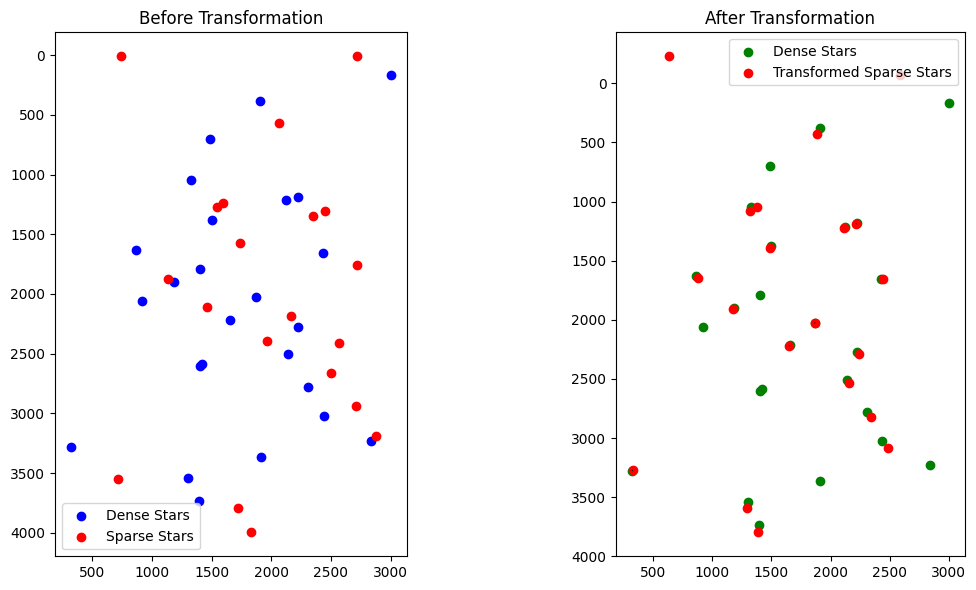

In [15]:
# Example call (assuming you still have first_img and second_img loaded)
plot_star_alignment(
    first_img_codrs,
    second_img_cords,
    transformed_sparse=apply_transform(
        np.array([s[:2] for s in detect_stars(first_img_path)]),
        transform[0], transform[1], transform[2]
    ),
    matches=matches
)